In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import spacy
from collections import Counter
from collections import defaultdict
import math
import re

nlp = spacy.load("en_core_web_sm")

def preprocess_text_spacy(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\t\n]+', ' ', text)
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            cleaned_token = token.lemma_.strip()
            cleaned_token = cleaned_token.lower()
            cleaned_token = re.sub(r'\s+', ' ', cleaned_token)
            if cleaned_token:
                cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

def preprocess_text_spacy_remain_stop_words(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\t\n]+', ' ', text)
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if not token.is_punct and token.is_alpha:
            cleaned_token = token.lemma_.strip()
            cleaned_token = cleaned_token.lower()
            cleaned_token = re.sub(r'\s+', ' ', cleaned_token)
            if cleaned_token:
                cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

In [3]:
import json

def load_json_as_list(file_path):
    with open(file_path, 'r') as file:
        data_dicts = [json.loads(line) for line in file]
    return data_dicts

high_quality_path = 'drive/MyDrive/webscience/data/credModelFiles/highQuality.json'
low_quality_path = 'drive/MyDrive/webscience/data/credModelFiles/lowQuality.json'
bg_quality_path = 'drive/MyDrive/webscience/data/credModelFiles/bgQuality.json'

high_quality_tweets = load_json_as_list(high_quality_path)
low_quality_tweets = load_json_as_list(low_quality_path)
bg_quality_tweets = load_json_as_list(bg_quality_path)

print(f"High quality tweets: {len(high_quality_tweets)}")
print(f"Low quality tweets: {len(low_quality_tweets)}")
print(f"Background tweets: {len(bg_quality_tweets)}")

High quality tweets: 2501
Low quality tweets: 1527
Background tweets: 2239


In [4]:
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")

def preprocess_tweets_and_extract_score(tweets):
    texts = [" ".join(preprocess_text_spacy(tweet["text"])) for tweet in tweets]
    scores = [tweet.get("score", None) for tweet in tweets]
    return texts, scores

def preprocess_tweets_and_extract_score_remain_stop_words(tweets):
    texts = [" ".join(preprocess_text_spacy_remain_stop_words(tweet["text"])) for tweet in tweets]
    scores = [tweet.get("score", None) for tweet in tweets]
    return texts, scores


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
from joblib import dump

hq_texts, _ = preprocess_tweets_and_extract_score(high_quality_tweets)
lq_texts, _ = preprocess_tweets_and_extract_score(low_quality_tweets)
bg_texts = [" ".join(tweet["text"]) for tweet in bg_quality_tweets]

hq_texts_rs, _ = preprocess_tweets_and_extract_score_remain_stop_words(high_quality_tweets)
lq_texts_rs, _ = preprocess_tweets_and_extract_score_remain_stop_words(low_quality_tweets)

In [6]:
bg_list = []

def make_list(word_list):
  words = [word for text in word_list for word in text.split()]
  return list(set(words))

hq_list = make_list(hq_texts)
lq_list = make_list(lq_texts)

hq_list_rs = make_list(hq_texts_rs)
lq_list_rs = make_list(lq_texts_rs)

for temp in bg_quality_tweets:
  bg_list.extend(temp['text'])
bg_list = list(set(bg_list))


In [7]:
from collections import Counter
def compute_tf_idf(word_list, corpus):
    tf = Counter(word_list)
    df = Counter()
    for doc in corpus:
        df.update(set(doc))
    total_docs = len(corpus)
    idf = {word: math.log((total_docs + 1) / (freq + 1)) + 1 for word, freq in df.items()}
    tf_idf = {word: (freq * idf.get(word,0)) for word, freq in tf.items()}

    return tf_idf

hq_texts_preprocessed = [preprocess_text_spacy(text) for text in hq_list]
lq_texts_preprocessed = [preprocess_text_spacy(text) for text in lq_list]

hq_texts_preprocessed_rs = [preprocess_text_spacy_remain_stop_words(text) for text in hq_list_rs]
lq_texts_preprocessed_rs = [preprocess_text_spacy_remain_stop_words(text) for text in lq_list_rs]

bg_texts_preprocessed = [preprocess_text_spacy(text) for text in bg_list]

In [8]:

hq_dict = compute_tf_idf(hq_list, hq_texts_preprocessed)
lq_dict = compute_tf_idf(lq_list, lq_texts_preprocessed)

hq_dict_rs = compute_tf_idf(hq_list, hq_texts_preprocessed_rs)
lq_dict_rs = compute_tf_idf(lq_list, lq_texts_preprocessed_rs)

bg_dict = compute_tf_idf(bg_list, bg_texts_preprocessed)

def my_sum(y):
  res = 0
  for c in y:
    res += c
  return res

def get_R(test_word, hq_dict, lq_dict, bg_dict):
    tf_t_HQ = hq_dict.get(test_word, 0)
    tf_t_LQ = lq_dict.get(test_word, 0)
    tf_t_BG = bg_dict.get(test_word, 1)

    FHQ = my_sum(hq_dict.values())
    FLQ = my_sum(lq_dict.values())
    FBG = my_sum(bg_dict.values())
    try:
      R_HQ_t = (tf_t_HQ / FHQ) / (tf_t_BG / FBG) if FHQ and FBG else 0
      R_LQ_t = (tf_t_LQ / FLQ) / (tf_t_BG / FBG) if FLQ and FBG else 0
    except ZeroDivisionError:
      R_HQ_t = 0
      R_LQ_t = 0

    S_HQ_t = R_HQ_t if R_HQ_t > 2 else 0
    S_LQ_t = R_LQ_t if R_LQ_t > 2 else 0
    return S_HQ_t, S_LQ_t

print(get_R('Fulham', hq_dict, lq_dict, bg_dict))
print(get_R('Fulham', hq_dict_rs, lq_dict_rs, bg_dict))

(0, 0)
(0, 0)


In [9]:
# tFtHQ = Counter(hq_list)
# tFtLQ = Counter(lq_list)
# tFtBG = Counter(bg_list)

# FHQ = my_sum(tFtHQ.values())
# FLQ = my_sum(tFtLQ.values())
# FBG = my_sum(tFtBG.values())

# def get_RS(test_word):
#   tf_t_HQ = tFtHQ.get(test_word, 0)
#   tf_t_LQ = tFtLQ.get(test_word, 0)
#   tf_t_BG = tFtBG.get(test_word, 1)

#   if(FHQ!=0 and FBG!=0 and FLQ!=0):
#     R_HQ_t = (tf_t_HQ / FHQ) / (tf_t_BG / FBG)
#     R_LQ_t = (tf_t_LQ / FLQ) / (tf_t_BG / FBG)
#   else:
#     R_HQ_t = 0
#     R_LQ_t = 0

#   S_HQ_t = R_HQ_t if R_HQ_t > 2 else 0
#   S_LQ_t = R_LQ_t if R_LQ_t > 2 else 0
#   return S_HQ_t, S_LQ_t
# print(get_RS('Fulham'))

In [10]:
def calculate_newsworthiness_score(document):
  terms = document
  sum_SQHt = 0
  sum_SQLt = 0
  for term in terms:
    SQHt, SQLt = get_R(term, hq_dict, lq_dict, bg_dict)
    # SQHt, SQLt = get_RS(term)
    sum_SQHt += SQHt
    sum_SQLt += SQLt
  Nd = np.log2((1 + sum_SQHt) / (1 + sum_SQLt))
  return Nd

def calculate_newsworthiness_score_rs(document):
  terms = document
  sum_SQHt = 0
  sum_SQLt = 0
  for term in terms:
    SQHt, SQLt = get_R(term, hq_dict_rs, lq_dict_rs, bg_dict)
    # SQHt, SQLt = get_RS(term)
    sum_SQHt += SQHt
    sum_SQLt += SQLt
  Nd = np.log2((1 + sum_SQHt) / (1 + sum_SQLt))
  return Nd

test_document = ['I', 'like', 'Fulham']
newsworthiness_score = calculate_newsworthiness_score(test_document)
print(newsworthiness_score)
newsworthiness_score_rs = calculate_newsworthiness_score_rs(test_document)
print(newsworthiness_score_rs)

-2.126852438406558
-2.1167081703466386


In [11]:
res_dict = []
for i in range(1,6,1):
    file_path = 'drive/MyDrive/webscience/data/datajson/geoLondonSep2022_{}.json'.format(i)

    with open(file_path, 'r') as file:
        tweets_data = json.load(file)
    res_dict.extend(tweets_data)

In [12]:
test_data, _ = preprocess_tweets_and_extract_score(res_dict)
test_data_rs, _ = preprocess_tweets_and_extract_score_remain_stop_words(res_dict)

In [13]:
count_p = 0
count_n = 0
count_0 = 0
for i in range(len(test_data)):
  t = test_data[i]
  x = t.split()
  total = calculate_newsworthiness_score(x)
  if(total>0):
    count_p += 1
  elif(total<0):
    count_n += 1
  else:
    count_0 += 1
  res_dict[i]['final'] = total
print('remove stop words')
print(count_p,count_n,count_0)


remove stop words
1795 11345 52


In [14]:
count_p = 0
count_n = 0
count_0 = 0
for i in range(len(test_data_rs)):
  t = test_data_rs[i]
  x = t.split()
  total = calculate_newsworthiness_score_rs(x)
  if(total>0):
    count_p += 1
  elif(total<0):
    count_n += 1
  else:
    count_0 += 1
  res_dict[i]['final_rs'] = total
print('remain stop words')
print(count_p,count_n,count_0)

remain stop words
1952 11201 39


In [15]:
threshold = -1.6
delta = 0.05
count = 0

for i in range(len(res_dict)):
    if res_dict[i]['final_rs'] <=[ threshold]:
        count += 1

print(count)
print(len(res_dict)-count)

7751
5441


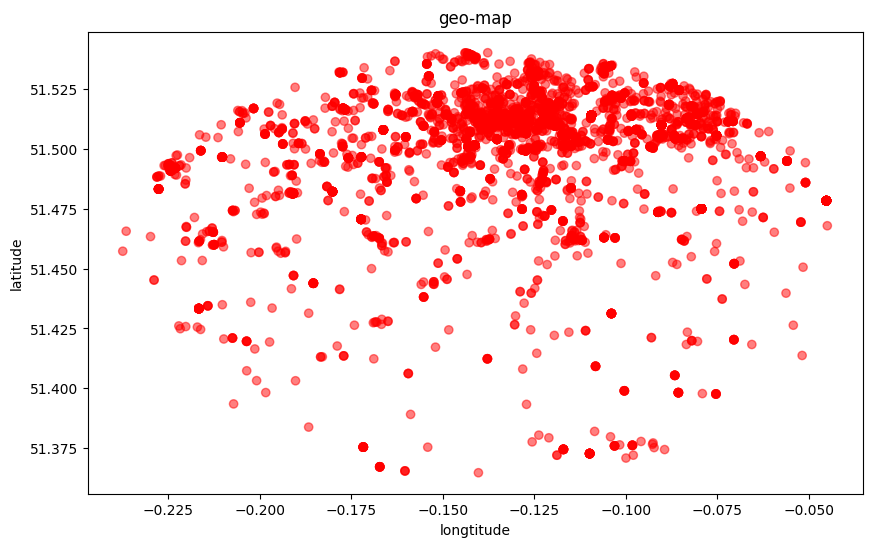

In [16]:
import matplotlib.pyplot as plt
threshode = -1.6
coordinates_list = []
colors = []

for tweet in res_dict:
    if tweet['coordinates'] and tweet['final_rs']>threshold:
        coordinates_list.append((tweet['coordinates'][0], tweet['coordinates'][1]))
        color = 'red'
        colors.append(color)

lons, lats = zip(*coordinates_list)

plt.figure(figsize=(10, 6))
plt.scatter(lons, lats, alpha=0.5, c=colors)
plt.title('geo-map')
plt.xlabel('longtitude')
plt.ylabel('latitude')
plt.show()


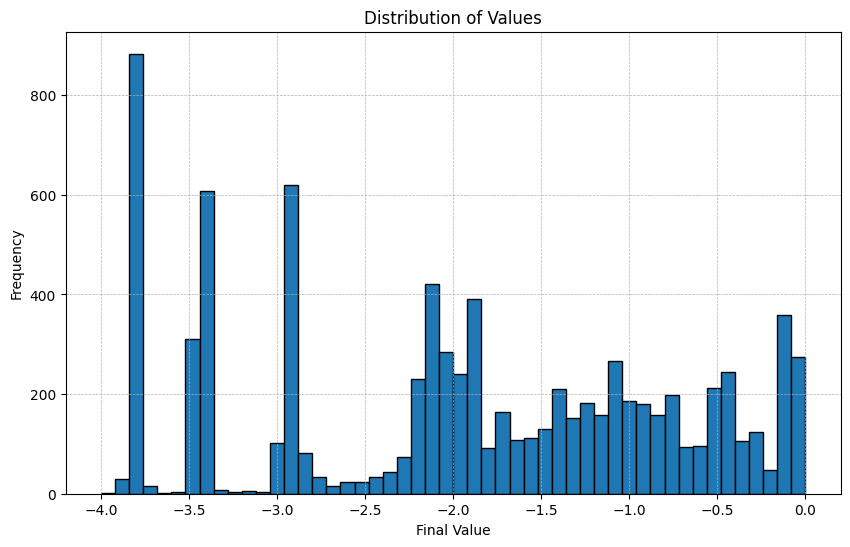

In [17]:
import matplotlib.pyplot as plt
def value_bar(tag):
  final_values = [d[tag] for d in res_dict]
  plt.figure(figsize=(10, 6))
  plt.hist(final_values, bins=50, edgecolor='black', range=(-4, 0))
  plt.title('Distribution of Values')
  plt.xlabel('Final Value')
  plt.ylabel('Frequency')
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.axhline(0, color='black', linewidth=0.5)
  plt.show()

# value_bar('final')
value_bar('final_rs')

In [18]:
import math
sw_corner_lat, sw_corner_lon = 51.2867602, -0.5103751
ne_corner_lat, ne_corner_lon = 51.6918741, 0.3340155
grid_map_positive = {}
grid_map_negative = {}
grid_map_positive_rs = {}
grid_map_negative_rs = {}

for tweet in res_dict:
    if 'coordinates' in tweet and tweet['coordinates']:
        lon, lat = tweet['coordinates']
        grid_x = int((lon - sw_corner_lon) * 111.320 * math.cos(math.radians(sw_corner_lat)))
        grid_y = int((lat - sw_corner_lat) * 110.574)
        target_grid_map = grid_map_positive if tweet['final'] >= threshode else grid_map_negative
        target_grid_map_rs = grid_map_positive_rs if tweet['final_rs']>=threshode else grid_map_negative_rs
        if (grid_x, grid_y) not in target_grid_map:
            target_grid_map[(grid_x, grid_y)] = []
        if (grid_x, grid_y) not in target_grid_map_rs:
            target_grid_map_rs[(grid_x, grid_y)] = []
        target_grid_map[(grid_x, grid_y)].append(tweet['_id'])
        target_grid_map_rs[(grid_x, grid_y)].append(tweet['_id'])


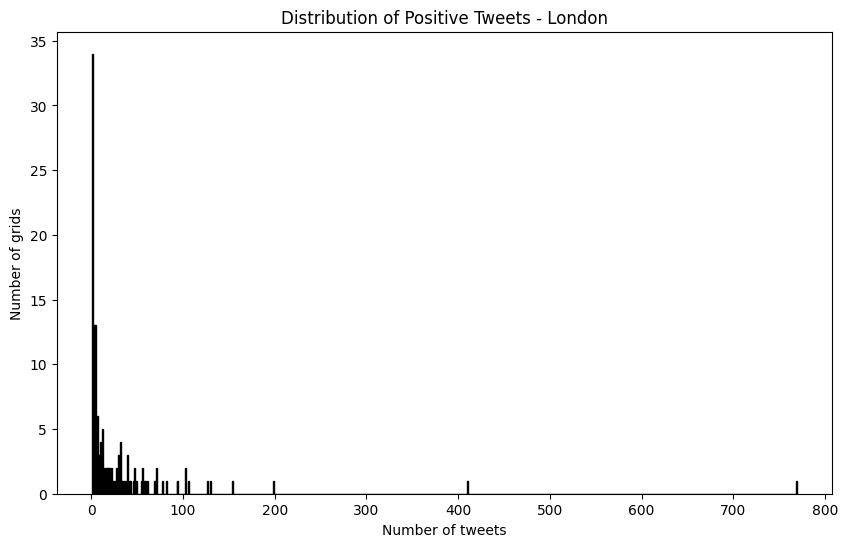

In [19]:
import matplotlib.pyplot as plt

def plot_tweet_distribution(grid_map, color, title):
    tweets_per_grid = [len(tweet_ids) for tweet_ids in grid_map.values()]
    plt.figure(figsize=(10, 6))
    plt.hist(tweets_per_grid, bins=range(1, max(tweets_per_grid)+1), color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of tweets')
    plt.ylabel('Number of grids')
    plt.show()

plot_tweet_distribution(grid_map_positive, 'green', 'Distribution of Positive Tweets - London')
# plot_tweet_distribution(grid_map_negative, 'red', 'Distribution of Negative Tweets - London')



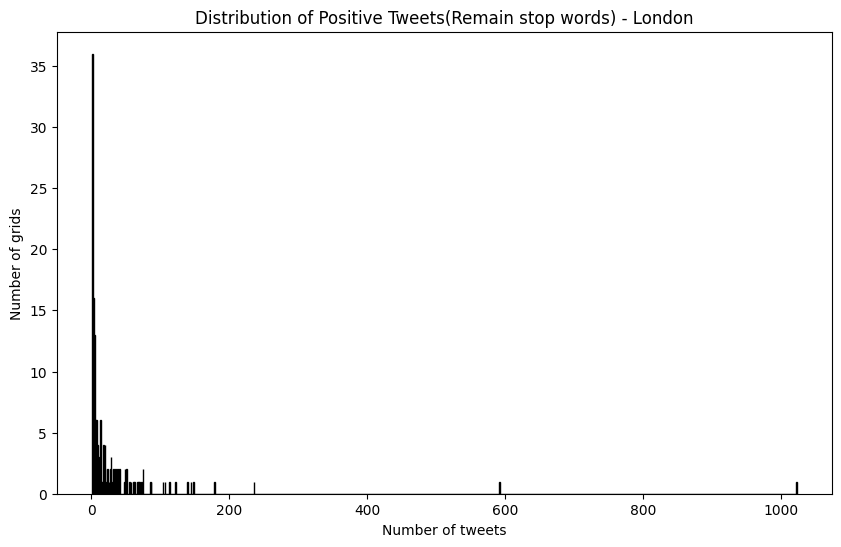

In [20]:
plot_tweet_distribution(grid_map_positive_rs, 'green', 'Distribution of Positive Tweets(Remain stop words) - London')
# plot_tweet_distribution(grid_map_negative_rs, 'red', 'Distribution of Negative Tweets(Remain stop words) - London')

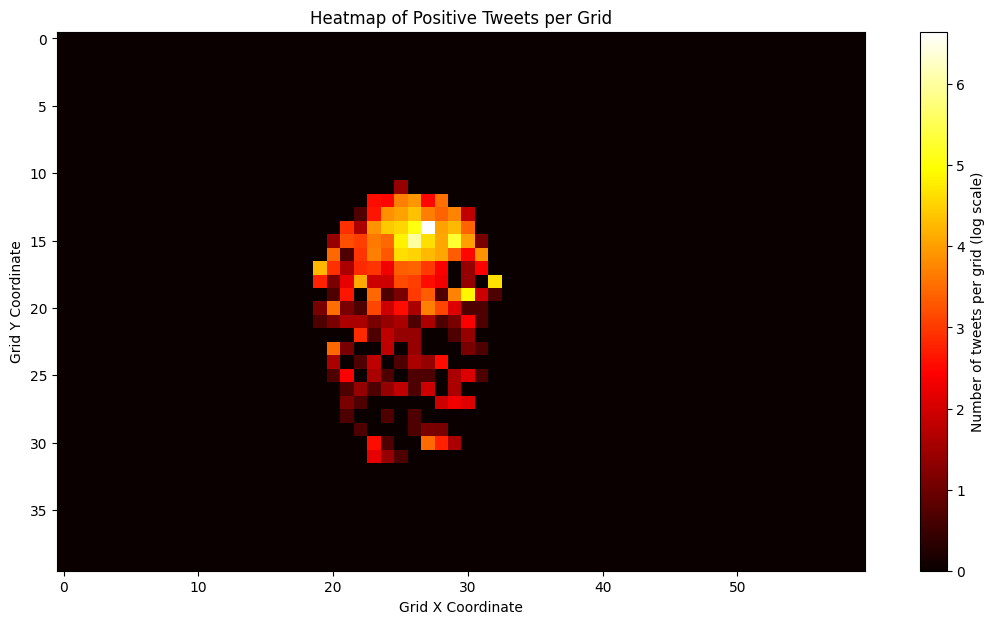

In [21]:

grid_size_x_positive = 60
grid_size_y_positive = 40
grid_array_positive = np.zeros((grid_size_y_positive, grid_size_x_positive))

# grid_size_x_negative = max(x for x, y in grid_map_negative.keys()) + 1
# grid_size_y_negative = max(y for x, y in grid_map_negative.keys()) + 1
# grid_array_negative = np.zeros((grid_size_y_negative, grid_size_x_negative))

for (x, y), tweet_ids in grid_map_positive.items():
      grid_array_positive[y, x] = len(tweet_ids)

# for (x, y), tweet_ids in grid_map_negative.items():
#     if 10 <= x <= 40 and 5 <= y <= 35:
#         grid_array_negative[y, x] = len(tweet_ids)

grid_array_positive = np.log1p(grid_array_positive)
# grid_array_negative = np.log1p(grid_array_negative)

def plot_heatmap(grid_array, title):
    plt.figure(figsize=(14, 7))
    plt.imshow(grid_array[::-1], cmap='hot', interpolation='nearest')
    plt.colorbar(label='Number of tweets per grid (log scale)')
    plt.title(title)
    plt.xlabel('Grid X Coordinate')
    plt.ylabel('Grid Y Coordinate')
    plt.show()

plot_heatmap(grid_array_positive, 'Heatmap of Positive Tweets per Grid')
# plot_heatmap(grid_array_negative, 'Heatmap of Negative Tweets per Grid')



In [22]:
tf_values = defaultdict(list)
doc_freq = Counter()
total_docs = sum(len(tweet_ids) for tweet_ids in grid_map_positive_rs.values())
tweet_id_to_text = {tweet["_id"]: tweet["text"] for tweet in res_dict}
for grid, tweet_ids in grid_map_positive_rs.items():
    for tweet_id in tweet_ids:
        tweet_text = tweet_id_to_text.get(tweet_id)
        if tweet_text:
            tokens = preprocess_text_spacy(tweet_text)
            tf = Counter(tokens)
            tf_values[grid].append(tf)
            doc_freq.update(set(tokens))

idf_values = {word: math.log((total_docs + 1) / (freq + 1)) + 1 for word, freq in doc_freq.items()}

tf_idf_values = {}
for grid, tfs in tf_values.items():
    grid_tf_idf = []
    for tf in tfs:
        tf_idf = {word: (tf[word] * idf_values[word]) for word in tf}
        grid_tf_idf.append(tf_idf)
    tf_idf_values[grid] = grid_tf_idf

grid_top_words = []
for grid, tf_idf_list in tf_idf_values.items():
    word_scores = defaultdict(float)
    for tf_idf in tf_idf_list:
        for word, score in tf_idf.items():
            word_scores[word] += score
    top_word = max(word_scores, key=word_scores.get)
    grid_top_words.append({
        'grid': grid,
        'top_word': top_word,
        'score': word_scores[top_word],
        'tweet_count': len(grid_map_positive_rs[grid])
    })
    print(f"The net {grid} has the toppest word is: {top_word}，with score: {word_scores[top_word]}，and total tweets are: {len(grid_map_positive_rs[grid])}")

The net (28, 15) has the toppest word is: otter，with score: 96.51392405537375，and total tweets are: 13
The net (25, 24) has the toppest word is: green，with score: 163.86908782209122，and total tweets are: 144
The net (22, 21) has the toppest word is: chelsea，with score: 230.07017270532526，and total tweets are: 66
The net (27, 25) has the toppest word is: united，with score: 2216.231263944479，and total tweets are: 1022
The net (23, 25) has the toppest word is: paddington，with score: 226.89077913157232，and total tweets are: 50
The net (27, 26) has the toppest word is: planning，with score: 92.44788841239496，and total tweets are: 40
The net (28, 25) has the toppest word is: paul，with score: 110.68461092174292，and total tweets are: 74
The net (28, 26) has the toppest word is: sutton，with score: 50.42804652581374，and total tweets are: 33
The net (30, 20) has the toppest word is: unιted，with score: 565.2524235006717，and total tweets are: 147
The net (26, 24) has the toppest word is: job，with sc

In [23]:
top_10_grids = sorted(grid_map_positive_rs.items(), key=lambda item: len(item), reverse=True)[:10]

for grid, tweet_count in top_10_grids:
    if grid in tf_idf_values:
        tf_idf_list = tf_idf_values[grid]
        word_scores = defaultdict(float)

        for tf_idf in tf_idf_list:
            for word, score in tf_idf.items():
                word_scores[word] += score

        top_10_words = sorted(word_scores.items(), key=lambda item: item[1], reverse=True)[:10]

        print(f"Grid {grid} with tweet count {tweet_count} has top words:")
        for word, score in top_10_words:
            print(f"Word: {word}, Score: {score}")

Grid (28, 15) with tweet count [1565423119363461121, 1568194151547535365, 1568188573106716673, 1567820764023504897, 1567804844907397122, 1568573197523775489, 1568571119669739521, 1569669353636827136, 1569661662738669568, 1569650535401144320, 1570034441954947075, 1572238546639126528, 1574880601714335754] has top words:
Word: otter, Score: 96.51392405537375
Word: trading, Score: 90.51697966646316
Word: vegan, Score: 22.567381132990064
Word: gift, Score: 21.897950479047438
Word: new, Score: 20.186907560102494
Word: cake, Score: 19.27154426698574
Word: decoration, Score: 17.00657926135016
Word: ownmade, Score: 17.00657926135016
Word: card, Score: 16.4312151164466
Word: curry, Score: 15.984928013818182
Grid (25, 24) with tweet count [1565417544617721856, 1565289000365133832, 1565274379004813312, 1565076068750458880, 1565710930716962818, 1565704402417160192, 1565662179797393408, 1566118945890902022, 1566031743152521217, 1565997679922106368, 1565995655801208833, 1565839795141632000, 156581089

In [24]:
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
num_grids_lat = int((ne_corner_lat - sw_corner_lat) * 110.574)
num_grids_lon = int((ne_corner_lon - sw_corner_lon) * 111.320 * math.cos(math.radians(sw_corner_lat)))
total_tweets = sum(len(tweet_ids) for tweet_ids in grid_map_positive_rs.values())
def calculate_grid_center(grid_index):
    grid_size_lat = (ne_corner_lat - sw_corner_lat) / num_grids_lat
    grid_size_lon = (ne_corner_lon - sw_corner_lon) / num_grids_lon
    center_lat = sw_corner_lat + (grid_index[1] + 0.5) * grid_size_lat
    center_lon = sw_corner_lon + (grid_index[0] + 0.5) * grid_size_lon

    return center_lon,center_lat

def calculate_grid_center_switch(grid):
  t = calculate_grid_center(grid)
  return t[1]-0.0045,t[0]-0.0071

adjusted_coordinates_list = [(lat, lon) for lon, lat in coordinates_list]
if adjusted_coordinates_list:
    map_center = [adjusted_coordinates_list[0][0], adjusted_coordinates_list[0][1]]
else:
    map_center = [0, 0]

m = folium.Map(location=map_center, zoom_start=6)

# for (grid_x, grid_y), tweet_ids in grid_map_positive_rs.items():
#     center_lat = sw_corner_lat + (grid_y + 0.5) / 110.574
#     center_lon = sw_corner_lon + (grid_x + 0.5) / (111.320 * math.cos(math.radians(sw_corner_lat)))
#     folium.Marker(
#         [center_lat, center_lon],
#         icon=folium.DivIcon(html=f"""<div style="font-size: 8pt; color: blue;">({grid_x},{grid_y})</div>""")
#     ).add_to(m)

for item in grid_top_words:
    grid_center = calculate_grid_center_switch(item['grid'])
    pstr = f"{item['top_word']} \n {item['tweet_count']}"
    marker = folium.Marker(
        location=grid_center,
        popup=f"{item['top_word']} \n {item['tweet_count']}",
        # icon=folium.Icon(icon='info-sign')
        icon=folium.DivIcon(html=f"""<div style="font-size: 8pt; color: blue;">{pstr}</div>""")
    )
    marker.add_to(m)

for (grid_x, grid_y) in grid_map_positive_rs.keys():
    bottom_left = [sw_corner_lat + grid_y / 110.574, sw_corner_lon + grid_x / (111.320 * math.cos(math.radians(sw_corner_lat)))]
    bottom_right = [bottom_left[0], bottom_left[1] + 1 / (111.320 * math.cos(math.radians(sw_corner_lat)))]
    top_left = [bottom_left[0] + 1 / 110.574, bottom_left[1]]
    top_right = [top_left[0], bottom_right[1]]
    folium.PolyLine([bottom_left, bottom_right, top_right, top_left, bottom_left], color="blue", weight=1).add_to(m)


HeatMap(adjusted_coordinates_list).add_to(m)

m